#### Simple test

Simpler example with synthetic data for testing purposes

Similar to https://demregpy--13.org.readthedocs.build/en/13/generated/gallery/running_demregpy.html

* 24-Sep-2025 IGH

In [1]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io

# So can have single copy of demreg on system, and don't need copy in working directory
from sys import path as sys_path
# Change to your local copy's location...
sys_path.append('/Users/iain/github/demreg/python')
from dn2dem_pos import dn2dem_pos

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

In [2]:
# Load in the SSWIDL generated response functions
# Was produced by make_aiaresp_forpy.pro (can't escape sswidl that easily....)
trin=io.readsav('aia_tresp_en.dat')

# Get rid of the b in the string name (byte vs utf stuff....)
for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")
print(trin['channels'])

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]
matplotlib.rcParams['font.size'] = 16

['A94' 'A131' 'A171' 'A193' 'A211' 'A335']


In [3]:
# For some DEM model (i.e. a Gaussian) produce the synthetic DN/s/px for each AIA channel
d1=4e22
m1=6.5
s1=0.15
root2pi=(2.*math.pi)**0.5
dem_mod=(d1/(root2pi*s1))*np.exp(-(tresp_logt-m1)**2/(2*s1**2))

# Now work out the DN/s/px
# For AIA responses all are dlogt=0.05
tresp_dlogt=np.full(nt,0.05)
tc_full=np.zeros([nt,nf])
for i in range(0,nf):
    tc_full[:,i]=dem_mod*trmatrix[:,i]*10**tresp_logt*np.log(10**tresp_dlogt)

dn_in=np.sum(tc_full,0)
print('dn_in: ',dn_in)

# And the associated uncertainty (no systematics)
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
# assume all obs were 2.9s long
dn0=dn_in*2.9
shotnoise=(dn2ph*dn0)**0.5/dn2ph/2.9
# error in DN/s/px
edn_in=(rdnse**2+shotnoise**2)**0.5 
print('edn_in: ',edn_in)

dn_in:  [  326.11015384   313.31711081  2663.51032443 11361.19771881
  8700.35613926  1208.36625448]
edn_in:  [14.94543537 12.67184957 32.12696433 61.39593307 51.38885685 15.53907416]


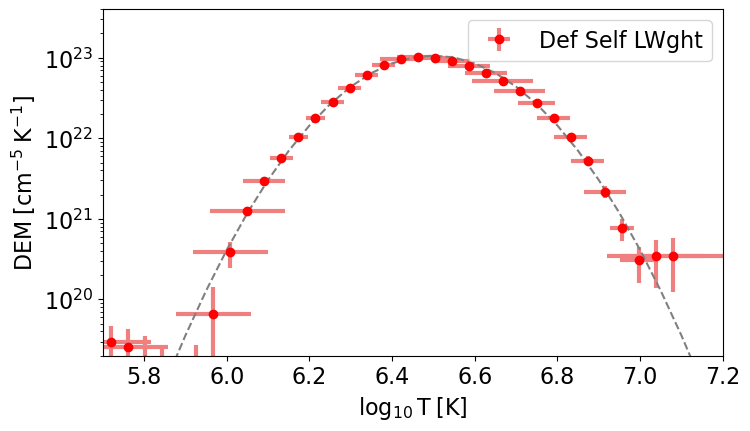

In [4]:
#  Setup the T binning for DEM solution
temps=np.logspace(5.7,7.1,num=35)
# temps=10**np.arange(5.7,7.1+0.05,0.05)
# Temperature bin mid-points for DEM plotting
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

# Now work out the DEM 
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps) 

#  Plot it all
yr=[2e19,4e23]
xr=[5.7,7.2]#np.log10([min(temps),max(temps)])
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0,label='Def Self LWght')
plt.plot(tresp_logt,dem_mod,'--',color='grey')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
plt.show()